# An Analysis of PaySim: Synthetic Financial Dataset for Fraud Detection
# ISYS 812 - Fall 2019
# Hua Lu, Kelley Nelson, Sai Punith, Xiaomin Lin

## Data cleaning

In [1]:
#Load libraries
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt

#Load original dataset and explore data.
paysim_orig = pd.read_csv ('paysim.csv')
paysim_orig.shape
paysim_orig.head()

print (paysim_orig.count())

There are no missing values. However, the data set is very large so we take a 10% sample size.

paysim = paysim_orig.sample (frac = .1, random_state = 1) 
#selecting a number for random_state means the sample can be reproduced

We check that the percentage of fraud cases is similar between the original and sample datasets.

fraud_orig = paysim_orig[paysim_orig['isFraud'] == 1].shape[0] / paysim_orig.shape [0]
fraud_orig = round (fraud_orig, 7)
print ('Percentage of fraud cases in original dataset: ' + str (fraud_orig *100) + '%')
fraud_sample = paysim[paysim['isFraud'] == 1].shape[0] / paysim.shape [0]
fraud_sample = round (fraud_sample, 7)
print ('Percentage of fraud cases in sample dataset: ' + str (fraud_sample *100) + '%')

paysim.to_csv ('paysim_sample.csv', index = False)

In [2]:
paysim = pd.read_csv ('paysim_sample.csv')
paysim.shape

(636262, 11)

The number of isFlaggedFraud cases in the original dataset is very small. We check to see whether there are any "flagged fraud" cases in the sample.

In [3]:
isFlagged = paysim [paysim ['isFlaggedFraud'] == 1]
isFlagged

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


Since there are no "flagged fraud" cases in the sample and we are not using it for our analysis, we remove that column. 

In [4]:
paysim = paysim.drop('isFlaggedFraud', axis = 1)

In the 'nameDest' column, an 'M' indicates the destination account is a merchant. 

In [5]:
#Create function to indetify merchants vs. non-merchants.
def is_merchant (vec):
    for item in vec:
        if 'C' in item:
            return 0
        if 'M' in item:
            return 1

#Apply function to 'nameDest'.
paysim ['is_merchant'] = paysim ['nameDest'].apply (is_merchant)
paysim.head(10)

#Remove 'step', nameOrig' and 'nameDest' columns.
paysim = paysim.drop(['nameOrig', 'nameDest', 'step'], axis = 1)
paysim.head ()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_merchant
0,CASH_IN,23557.12,8059.00,31616.12,169508.66,145951.53,0,0
1,PAYMENT,6236.13,0.00,0.00,0.00,0.00,0,1
2,PAYMENT,33981.87,18745.72,0.00,0.00,0.00,0,1
3,CASH_OUT,263006.42,20072.00,0.00,390253.56,653259.98,0,0
4,CASH_OUT,152013.74,20765.00,0.00,252719.19,404732.93,0,0


## Data Analysis

### Analysis #1: Is there any difference in the proportion of fraudulent transactions involving merchants vs. non-merchants?

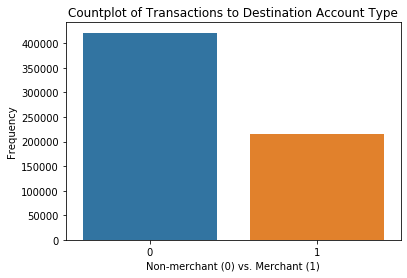

In [6]:
#Plot the number of transactions involving merchants as compared to non-merchants.
count, ax = plt.subplots()
ax = sns.countplot (x = 'is_merchant', data = paysim)
ax.set_title ("Countplot of Transactions to Destination Account Type")
ax.set_xlabel ("Non-merchant (0) vs. Merchant (1)")
ax.set_ylabel ("Frequency")
plt.show()

In [7]:
#Group the data by merchant vs. non-merchant, and sum the number of fraudulent cases for each. 
merch_cust = paysim.groupby('is_merchant').isFraud.sum().reset_index()
merch_cust

,is_merchant,isFraud
0,0,819
1,1,0


Analysis #1 conclusion: There are no fraudulent transactions involving merchants.

### Analysis #2: Which types of transactions are fraudulent? What amount of fraudulent transactions does each type have? 

In [8]:
#Check Dataset informatiom
paysim.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_merchant
count,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,636262.000000,636262.000000
mean,1.797005e+05,8.366566e+05,8.579998e+05,1.096128e+06,1.220355e+06,0.001287,0.337469
std,5.913780e+05,2.892569e+06,2.928367e+06,3.303671e+06,3.578730e+06,0.035855,0.472847
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.338487e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,7.527145e+04,1.416326e+04,0.000000e+00,1.330648e+05,2.150250e+05,0.000000,0.000000
75%,2.090753e+05,1.074859e+05,1.448757e+05,9.462169e+05,1.114690e+06,0.000000,1.000000
max,6.750076e+07,5.731626e+07,4.731626e+07,3.281945e+08,3.279981e+08,1.000000,1.000000


In [9]:
#get transactions' type and count
paysim['type'].value_counts()

CASH_OUT    223880
PAYMENT     214719
CASH_IN     140287
TRANSFER     53211
DEBIT         4165
Name: type, dtype: int64

In [10]:
#By using groupby by type: we will find out that there are
# only two types of transaction have Fraud occured.
total_fraud = paysim.groupby(['type']).sum().reset_index()
total_fraud

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_merchant
0,CASH_IN,2.364494e+10,5.040787e+11,5.277232e+11,2.223363e+11,2.054089e+11,0,0
1,CASH_OUT,3.960701e+10,1.028621e+10,3.897205e+09,3.343372e+11,3.778505e+11,420,0
2,DEBIT,2.292168e+07,2.906248e+08,2.761854e+08,5.872148e+09,5.957323e+09,0,0
3,PAYMENT,2.799228e+09,1.477273e+10,1.340902e+10,0.000000e+00,0.000000e+00,0,214719
4,TRANSFER,4.826248e+10,2.904495e+09,6.070343e+08,1.348788e+11,1.872491e+11,399,0


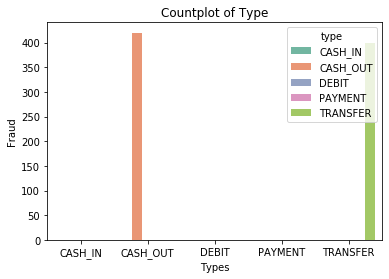

In [11]:
#create histgram:
count, ax = plt.subplots()

ax = sns.barplot(x ='type', y ='isFraud', data = total_fraud, hue='type' , palette ="Set2")

ax.set_title('Countplot of Type')
ax.set_xlabel('Types')
ax.set_ylabel('Fraud')

plt.show()

In [12]:
cash_out = total_fraud['amount'][1].sum()
cash_out

39607009549.65948

In [13]:
transfer = total_fraud['amount'][4].sum()
transfer

48262484436.690506

#### Analysis 2 conclusion: only cash_out and transfer appear fraud transactions. They amount of cash_out fraud is #39,607,009,549.65948 and transfer is $48,262,484,436.690506.


### Analysis #3: How to judge the fraudulent transactions? The difference between the new balance of fraudulent transaction and old balance.

In [14]:
True_Fraud = paysim[paysim.isFraud == 1]
Non_Fraud = paysim[paysim.isFraud == 0]

In [15]:
True_Fraud.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_merchant
218,CASH_OUT,472692.51,472692.51,0.0,193065.83,665758.34,1,0
437,TRANSFER,70696.74,70696.74,0.0,0.00,0.00,1,0
820,CASH_OUT,1418198.25,1418198.25,0.0,1488632.50,2906830.75,1,0
1288,TRANSFER,91637.51,91637.51,0.0,0.00,0.00,1,0
1433,CASH_OUT,455788.55,455788.55,0.0,0.00,455788.55,1,0


In [16]:
Non_Fraud.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_merchant
0,CASH_IN,23557.12,8059.00,31616.12,169508.66,145951.53,0,0
1,PAYMENT,6236.13,0.00,0.00,0.00,0.00,0,1
2,PAYMENT,33981.87,18745.72,0.00,0.00,0.00,0,1
3,CASH_OUT,263006.42,20072.00,0.00,390253.56,653259.98,0,0
4,CASH_OUT,152013.74,20765.00,0.00,252719.19,404732.93,0,0


In [17]:
# Find the difference between oldbalanceOrg and newbalanceOrig
True_Fraud['diff_old_newOrg'] = (True_Fraud['newbalanceOrig'] - True_Fraud['oldbalanceOrg']).abs()
True_Fraud.head()

/Users/helloconey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_merchant,diff_old_newOrg
218,CASH_OUT,472692.51,472692.51,0.0,193065.83,665758.34,1,0,472692.51
437,TRANSFER,70696.74,70696.74,0.0,0.00,0.00,1,0,70696.74
820,CASH_OUT,1418198.25,1418198.25,0.0,1488632.50,2906830.75,1,0,1418198.25
1288,TRANSFER,91637.51,91637.51,0.0,0.00,0.00,1,0,91637.51
1433,CASH_OUT,455788.55,455788.55,0.0,0.00,455788.55,1,0,455788.55


In [18]:
Non_Fraud['diff_old_newOrg'] = (Non_Fraud['newbalanceOrig'] - Non_Fraud['oldbalanceOrg']).abs()
Non_Fraud.head()

/Users/helloconey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_merchant,diff_old_newOrg
0,CASH_IN,23557.12,8059.00,31616.12,169508.66,145951.53,0,0,23557.12
1,PAYMENT,6236.13,0.00,0.00,0.00,0.00,0,1,0.00
2,PAYMENT,33981.87,18745.72,0.00,0.00,0.00,0,1,18745.72
3,CASH_OUT,263006.42,20072.00,0.00,390253.56,653259.98,0,0,20072.00
4,CASH_OUT,152013.74,20765.00,0.00,252719.19,404732.93,0,0,20765.00


In [19]:
#Get the average of difference between old balance original and new balance original
mean_of_true_difference = True_Fraud['diff_old_newOrg'].mean()
mean_of_true_difference

1378861.9153724068

In [20]:
mean_of_non_difference = Non_Fraud['diff_old_newOrg'].mean()
mean_of_non_difference

51271.048304944896

[0, 3, -200000, 200000]

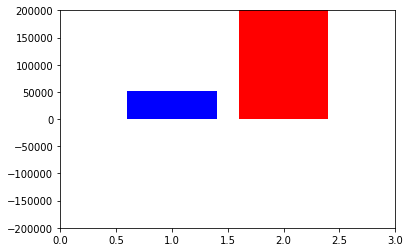

In [21]:
# Graph and make it visualize 
fig, ax = plt.subplots()


ax.bar(1,mean_of_non_difference,width = 0.8, align='center', color = 'Blue')
ax.bar(2,mean_of_true_difference, width = 0.8, align = 'center', color = 'Red')

plt.axis([0, 3, -200000, 200000])

#### Analysis 3 conclusion: The difference between the account balance before and after of the non-fraudulent transaction is not large and is mostly positive. And the fraudulent transaction in the transfer or cash_out, the difference of before and after account balance is usually large with negative number.

### Analysis #4: In the dataset, the “amount” column represents the money amount of the specific transaction while the “oldbalanceOrg” column means the original balance of the remitters. Is there any relationship between these 2 factors and the fraud determination, especially when the amount of these 2 factors are the same? 

this is not part of the main analysis A small analysis where the summary states that isflaggedfraud is marked if the transaction is above 200000 but we can clearly see thats not always true.

paysimTransfer = paysim.loc[paysim.type == 'TRANSFER']
paysimTransfer.loc[paysimTransfer.isFlaggedFraud == 0].amount.max()

same as above this is not part of the main analysis .Another small analysis wherein the receiver who is marked fraud has had two transactions.

In [23]:
#a=paysim[paysim['isFraud']==1]
#dups= a.pivot_table(index=['nameDest'], aggfunc='size')
#print(dups[dups>1])

STEP 1: We check for those transactions where the difference of old balance and amount is not equal to the new balance.

In [24]:
paysim['wrongbal'] = paysim["oldbalanceOrg"] - paysim["amount"] != paysim["newbalanceOrig"]
paysim.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_merchant,wrongbal
0,CASH_IN,23557.12,8059.00,31616.12,169508.66,145951.53,0,0,True
1,PAYMENT,6236.13,0.00,0.00,0.00,0.00,0,1,True
2,PAYMENT,33981.87,18745.72,0.00,0.00,0.00,0,1,True
3,CASH_OUT,263006.42,20072.00,0.00,390253.56,653259.98,0,0,True
4,CASH_OUT,152013.74,20765.00,0.00,252719.19,404732.93,0,0,True


STEP 2: Checking the mean and maximum error for the senders balance 

In [25]:
paysim["errorBalanceOrg"] = paysim.newbalanceOrig + paysim.amount - paysim.oldbalanceOrg
paysim["errorBalanceDest"] = paysim.oldbalanceDest + paysim.amount - paysim.newbalanceDest

fraud = paysim[paysim["isFraud"] == 1]
valid = paysim[paysim["isFraud"] == 0]
print("fraudulent transactions: \n",fraud["errorBalanceOrg"].describe())
print("\n valid transactions: \n",valid["errorBalanceOrg"].describe())

fraudulent transactions: 
 count    8.190000e+02
mean     8.431139e+02
std      1.887102e+04
min     -1.862645e-09
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.087822e+05
Name: errorBalanceOrg, dtype: float64

 valid transactions: 
 count    6.354430e+05
mean     2.013017e+05
std      5.949441e+05
min     -1.000000e-02
25%      3.107980e+03
50%      6.973860e+04
75%      2.509289e+05
max      6.750076e+07
Name: errorBalanceOrg, dtype: float64


we check the mean,maximum and minimum errors for the receivers balance too.

In [26]:
print("Summary statistics of errorBalanceDest for fraudulent transactions: \n",fraud["errorBalanceDest"].describe())
print("\n Summary statistics of errorBalanceDest for valid transactions: \n",valid["errorBalanceDest"].describe())

Summary statistics of errorBalanceDest for fraudulent transactions: 
 count    8.190000e+02
mean     6.435922e+05
std      1.676194e+06
min     -6.603624e+05
25%      0.000000e+00
50%      1.000000e-02
75%      4.218270e+05
max      1.000000e+07
Name: errorBalanceDest, dtype: float64

 Summary statistics of errorBalanceDest for valid transactions: 
 count    6.354430e+05
mean     5.471483e+04
std      4.434844e+05
min     -7.588573e+07
25%      0.000000e+00
50%      3.516640e+03
75%      2.944268e+04
max      8.247637e+06
Name: errorBalanceDest, dtype: float64


STEP 3: As the values are large we plot them on the graph for better analysis

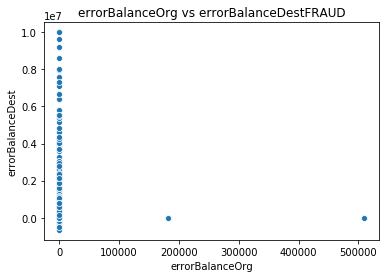

In [27]:
errors = ["errorBalanceOrg", "errorBalanceDest"]
count, ax = plt.subplots()
ax = sns.scatterplot (x = 'errorBalanceOrg',y='errorBalanceDest', data = fraud)
plt.title("errorBalanceOrg vs errorBalanceDestFRAUD")
plt.show()

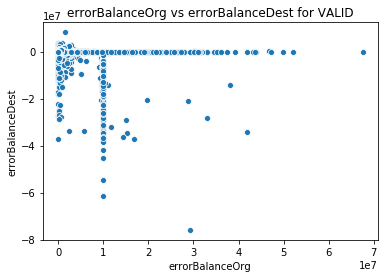

In [28]:
count, ax = plt.subplots()
ax = sns.scatterplot (x = 'errorBalanceOrg',y='errorBalanceDest', data = valid)
plt.title("errorBalanceOrg vs errorBalanceDest for VALID")
plt.show()

Conclusion: we can clearly see that the error balance for valid transactions lies below zero,whereas the error balance for fradulent transactions lies above zero.Thus the errorBalanceOrig and errorBalanceDest variables play a crucial role in Fraud Detection.

### Mia--Analysis #5: Is there any relationship between the amount and oldbalanceOrg concerning about the fraud?

In [29]:
paysim['oldbalanceOrgEqlAmt']=paysim['oldbalanceOrg'] == paysim ['amount']
paysim.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_merchant,wrongbal,errorBalanceOrg,errorBalanceDest,oldbalanceOrgEqlAmt
0,CASH_IN,23557.12,8059.00,31616.12,169508.66,145951.53,0,0,True,47114.24,47114.25,False
1,PAYMENT,6236.13,0.00,0.00,0.00,0.00,0,1,True,6236.13,6236.13,False
2,PAYMENT,33981.87,18745.72,0.00,0.00,0.00,0,1,True,15236.15,33981.87,False
3,CASH_OUT,263006.42,20072.00,0.00,390253.56,653259.98,0,0,True,242934.42,0.00,False
4,CASH_OUT,152013.74,20765.00,0.00,252719.19,404732.93,0,0,True,131248.74,0.00,False


In [30]:
oldbOrg_amt=pd.DataFrame(paysim['oldbalanceOrgEqlAmt'].value_counts())
oldbOrg_amt

,oldbalanceOrgEqlAmt
False,635457
True,805


In [31]:
isFraud=pd.DataFrame(paysim[paysim['isFraud']==1])
isFraud.count()[9]

819

In [32]:
oldbOrg_amt_isFraud=isFraud[isFraud['oldbalanceOrgEqlAmt']==True]
oldbOrg_amt_isFraud.count()[-1]

805

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from patsy import dmatrices
from sklearn.linear_model import LinearRegression

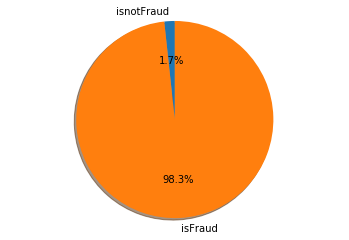

In [34]:
labels = 'isnotFraud', 'isFraud'
sizes = [14,805] 
explode = (0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Conclusion Analysis : Can fraud be predicted using logistic regression?

In [35]:
predictors1 = pd.get_dummies (paysim [['type', 'oldbalanceOrgEqlAmt', 'amount']], drop_first = True)
predictors1.head()

,oldbalanceOrgEqlAmt,amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,False,23557.12,0,0,0,0
1,False,6236.13,0,0,1,0
2,False,33981.87,0,0,1,0
3,False,263006.42,1,0,0,0
4,False,152013.74,1,0,0,0


In [36]:
lr1 = linear_model.LogisticRegression(solver='liblinear')
predicted1 = lr1.fit (X = predictors1, y = paysim ['isFraud'])
print (predicted1.coef_)
print (predicted1.intercept_)

[[ 1.69582171e-01 -6.30067577e-07 -9.77905301e-01 -8.31398464e-02
  -1.53968878e+00 -7.94938052e-02]]
[-3.76261076]


In [37]:
values = np.append (predicted1.intercept_, predicted1.coef_)

names = np.append ('intercept', predictors1.columns)

results = pd.DataFrame (values, index = names, columns = ['lr1_coef'])
results ['lr1_odds'] = np.exp (results ['lr1_coef'])
results

,lr1_coef,lr1_odds
intercept,-3.762611e+00,0.023223
oldbalanceOrgEqlAmt,1.695822e-01,1.184810
amount,-6.300676e-07,0.999999
type_CASH_OUT,-9.779053e-01,0.376098
type_DEBIT,-8.313985e-02,0.920222
type_PAYMENT,-1.539689e+00,0.214448
type_TRANSFER,-7.949381e-02,0.923584


In [38]:
#Step and amount do not appear to be signicant predictors of fraud, so we remove them from the model
predictors2 = pd.get_dummies (paysim [['type', 'oldbalanceOrgEqlAmt']], drop_first = True)
lr2 = linear_model.LogisticRegression(solver='liblinear')
predicted2 = lr2.fit (X = predictors2, y = paysim ['isFraud'])
print (predicted2.coef_)
print (predicted2.intercept_)

[[13.36782621 -0.07610576 -0.21602203 -1.93902549  1.37010337]]
[-9.67481608]


In [39]:
values = np.append (predicted2.intercept_, predicted2.coef_)

names = np.append ('intercept', predictors2.columns)

results = pd.DataFrame (values, index = names, columns = ['lr2_coef'])
results ['lr2_odds'] = np.exp (results ['lr2_coef'])
results

,lr2_coef,lr2_odds
intercept,-9.674816,0.000063
oldbalanceOrgEqlAmt,13.367826,639106.387417
type_CASH_OUT,-0.076106,0.926718
type_DEBIT,-0.216022,0.805718
type_PAYMENT,-1.939025,0.143844
type_TRANSFER,1.370103,3.935758
